<a href="https://colab.research.google.com/github/haresh93/ERA-submissions/blob/main/S10/S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/haresh93/ERA-submissions.git
%cd ERA-submissions/S10/

Cloning into 'ERA-submissions'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 110 (delta 43), reused 61 (delta 20), pack-reused 0
Receiving objects: 100% (110/110), 475.88 KiB | 8.98 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/ERA-submissions/S10


In [2]:
!pip3 install torch
!pip3 install torchvision
!pip3 install matplotlib
!pip3 install torchsummary
!pip3 install tqdm
!pip3 install cv2
!pip3 install albumentations
!pip3 install torch_lr_finder

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
cuda = torch.cuda.is_available()
print("Cuda Available: ", cuda)

device = torch.device("cuda" if cuda else "cpu")

Cuda Available:  True


In [5]:
# Train and Test Transforms
train_transforms = A.Compose([
        A.RandomCrop(width=32, height=32),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=8, max_width=8,
                       min_holes = 1, min_height=8, min_width=8, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None),
        A.Normalize( (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
])

test_transforms = A.Compose([
                                      A.Normalize( (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                      ToTensorV2(),
])

In [6]:
# Train and Test Datasets
from dataset import Cifar10SearchDataset
train_dataset = Cifar10SearchDataset('~/data/CIFAR10', train=True, download=True,
                    transform=train_transforms)
test_dataset = Cifar10SearchDataset('~/data/CIFAR10', train=False, download=True,
                    transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 49176805.20it/s]


Extracting /root/data/CIFAR10/cifar-10-python.tar.gz to /root/data/CIFAR10
Files already downloaded and verified


In [7]:
dataloader_args = dict(shuffle = True, batch_size = 512, num_workers = 4, pin_memory = True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

In [8]:
from custom_resnet import model_summary, Net

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

model_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E-02


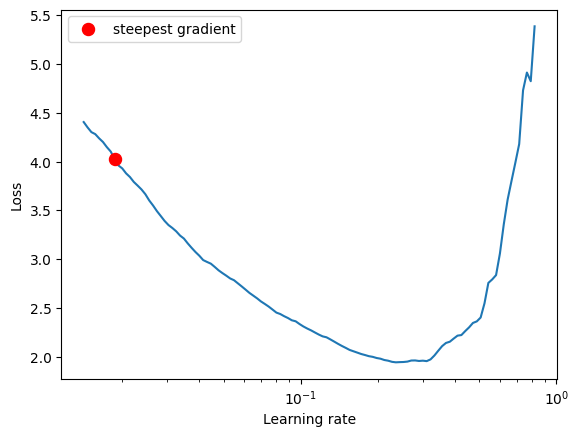

In [11]:
from torch_lr_finder import LRFinder

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 0.0001)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device = 'cuda')
lr_finder.range_test(train_dataloader, end_lr = 10, num_iter = 200, step_mode = "exp")
lr_finder.plot()
lr_finder.reset()

In [12]:
from torch.optim.lr_scheduler import OneCycleLR
from train import model_train, model_test

EPOCHS = 24

scheduler = OneCycleLR(
    optimizer,
    max_lr = 0.0187,
    steps_per_epoch=len(train_dataloader),
    epochs = EPOCHS,
    pct_start = 5/EPOCHS,
    div_factor=100,
    three_phase = False,
    final_div_factor=1000,
    anneal_strategy='linear'
)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_train(model, device, train_dataloader, optimizer, scheduler, criterion, epoch)
    model_test(model, device, test_dataloader, criterion)

EPOCH: 0


Train: Loss=1.0030 Batch_id=97 Accuracy=53.41: 100%|██████████| 98/98 [00:08<00:00, 11.19it/s]



Test set: Average loss: 0.0022, Accuracy: 6192/10000 (61.92%)

EPOCH: 1


Train: Loss=0.8839 Batch_id=97 Accuracy=71.91: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]



Test set: Average loss: 0.0019, Accuracy: 6872/10000 (68.72%)

EPOCH: 2


Train: Loss=0.5425 Batch_id=97 Accuracy=77.30: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]



Test set: Average loss: 0.0013, Accuracy: 7843/10000 (78.43%)

EPOCH: 3


Train: Loss=0.5342 Batch_id=97 Accuracy=78.82: 100%|██████████| 98/98 [00:09<00:00, 10.83it/s]



Test set: Average loss: 0.0012, Accuracy: 7852/10000 (78.52%)

EPOCH: 4


Train: Loss=0.4982 Batch_id=97 Accuracy=82.13: 100%|██████████| 98/98 [00:08<00:00, 11.10it/s]



Test set: Average loss: 0.0013, Accuracy: 7822/10000 (78.22%)

EPOCH: 5


Train: Loss=0.4777 Batch_id=97 Accuracy=83.90: 100%|██████████| 98/98 [00:08<00:00, 11.10it/s]



Test set: Average loss: 0.0010, Accuracy: 8230/10000 (82.30%)

EPOCH: 6


Train: Loss=0.4919 Batch_id=97 Accuracy=85.94: 100%|██████████| 98/98 [00:08<00:00, 11.14it/s]



Test set: Average loss: 0.0014, Accuracy: 7876/10000 (78.76%)

EPOCH: 7


Train: Loss=0.4206 Batch_id=97 Accuracy=86.83: 100%|██████████| 98/98 [00:08<00:00, 11.16it/s]



Test set: Average loss: 0.0013, Accuracy: 7949/10000 (79.49%)

EPOCH: 8


Train: Loss=0.3399 Batch_id=97 Accuracy=87.37: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]



Test set: Average loss: 0.0013, Accuracy: 7812/10000 (78.12%)

EPOCH: 9


Train: Loss=0.3607 Batch_id=97 Accuracy=88.40: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]



Test set: Average loss: 0.0010, Accuracy: 8309/10000 (83.09%)

EPOCH: 10


Train: Loss=0.3644 Batch_id=97 Accuracy=88.88: 100%|██████████| 98/98 [00:08<00:00, 11.02it/s]



Test set: Average loss: 0.0011, Accuracy: 8255/10000 (82.55%)

EPOCH: 11


Train: Loss=0.3453 Batch_id=97 Accuracy=89.35: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]



Test set: Average loss: 0.0010, Accuracy: 8392/10000 (83.92%)

EPOCH: 12


Train: Loss=0.3122 Batch_id=97 Accuracy=89.98: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]



Test set: Average loss: 0.0011, Accuracy: 8316/10000 (83.16%)

EPOCH: 13


Train: Loss=0.3433 Batch_id=97 Accuracy=90.32: 100%|██████████| 98/98 [00:08<00:00, 11.14it/s]



Test set: Average loss: 0.0012, Accuracy: 8154/10000 (81.54%)

EPOCH: 14


Train: Loss=0.3104 Batch_id=97 Accuracy=91.16: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]



Test set: Average loss: 0.0014, Accuracy: 7856/10000 (78.56%)

EPOCH: 15


Train: Loss=0.2039 Batch_id=97 Accuracy=92.22: 100%|██████████| 98/98 [00:08<00:00, 10.98it/s]



Test set: Average loss: 0.0008, Accuracy: 8578/10000 (85.78%)

EPOCH: 16


Train: Loss=0.1944 Batch_id=97 Accuracy=92.54: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]



Test set: Average loss: 0.0010, Accuracy: 8485/10000 (84.85%)

EPOCH: 17


Train: Loss=0.2082 Batch_id=97 Accuracy=93.52: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]



Test set: Average loss: 0.0009, Accuracy: 8643/10000 (86.43%)

EPOCH: 18


Train: Loss=0.2074 Batch_id=97 Accuracy=94.30: 100%|██████████| 98/98 [00:08<00:00, 11.01it/s]



Test set: Average loss: 0.0007, Accuracy: 8815/10000 (88.15%)

EPOCH: 19


Train: Loss=0.1126 Batch_id=97 Accuracy=95.47: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]



Test set: Average loss: 0.0008, Accuracy: 8677/10000 (86.77%)

EPOCH: 20


Train: Loss=0.0876 Batch_id=97 Accuracy=96.62: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]



Test set: Average loss: 0.0006, Accuracy: 9016/10000 (90.16%)

EPOCH: 21


Train: Loss=0.0580 Batch_id=97 Accuracy=97.77: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]



Test set: Average loss: 0.0006, Accuracy: 9105/10000 (91.05%)

EPOCH: 22


Train: Loss=0.0230 Batch_id=97 Accuracy=98.56: 100%|██████████| 98/98 [00:08<00:00, 11.02it/s]



Test set: Average loss: 0.0006, Accuracy: 9165/10000 (91.65%)

EPOCH: 23


Train: Loss=0.0244 Batch_id=97 Accuracy=99.19: 100%|██████████| 98/98 [00:08<00:00, 11.02it/s]



Test set: Average loss: 0.0005, Accuracy: 9193/10000 (91.93%)

